#  CAR PRICE PREDICTION DATA PREP. FOR ML MODEL                                                                   

The data set is taken from autoscout24 website. It is a manipulated and  messy dataset for  better understanding of Data Manipulation techniques.

In [305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import regex as re
import string as str

import warnings
warnings.filterwarnings("ignore")


In [306]:
df = pd.read_json("scout_car.json",  lines=True)
# we have to read this file line by line

In [307]:
df.head().T

,0,1,2,3,4
url,https://www.autoscout24.com//offers/audi-a1-sp...,https://www.autoscout24.com//offers/audi-a1-1-...,https://www.autoscout24.com//offers/audi-a1-sp...,https://www.autoscout24.com//offers/audi-a1-1-...,https://www.autoscout24.com//offers/audi-a1-sp...
make_model,Audi A1,Audi A1,Audi A1,Audi A1,Audi A1
short_description,Sportback 1.4 TDI S-tronic Xenon Navi Klima,1.8 TFSI sport,Sportback 1.6 TDI S tronic Einparkhilfe plus+m...,1.4 TDi Design S tronic,Sportback 1.4 TDI S-Tronic S-Line Ext. admired...
body_type,Sedans,Sedans,Sedans,Sedans,Sedans
price,15770,14500,14640,14500,16790
vat,VAT deductible,Price negotiable,VAT deductible,None,None
km,"56,013 km","80,000 km","83,450 km","73,000 km","16,200 km"
registration,01/2016,03/2017,02/2016,08/2016,05/2016
prev_owner,2 previous owners,None,1 previous owner,1 previous owner,1 previous owner
kW,NaN,NaN,NaN,NaN,NaN


Vat stands for value added tax which is generally 20 percent of cars.

In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15919 entries, 0 to 15918
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            15919 non-null  object 
 1   make_model                     15919 non-null  object 
 2   short_description              15873 non-null  object 
 3   body_type                      15859 non-null  object 
 4   price                          15919 non-null  int64  
 5   vat                            11406 non-null  object 
 6   km                             15919 non-null  object 
 7   registration                   15919 non-null  object 
 8   prev_owner                     9091 non-null   object 
 9   kW                             0 non-null      float64
 10  hp                             15919 non-null  object 
 11  Type                           15917 non-null  object 
 12  Previous Owners                9279 non-null  

kw will be dropped   
hp will be converted to numeric  
for type columnd pattern recog will be used.  
Previous Owners will include just numbers.
next inspection will include date
Next Inspection will be date
Inspection new, Warranty ,Full Service, Non-smoking Vehicle does not contain meaningful values at first glance.
So i will create a new df without these columns. But keep first df in case i can use these columns as well.
"null" column consists of "[]" so it will be dropped
Make column will be renamed as brand. Will be edited with regex
model column will be edited with regex
for now We will keep offer number as itself.
first registeration will be edited with regex
body color  will be edited with regex
Paint Type,Body Color Original,Upholstery,Body,Nr. of Doors,Nr. of Seats will be edited with regex
Model Code,Gearing Type	Displacement,Cylinders,Weight,Drive chain will be edited with regex and 
Weight will be converted to numeric.
Fuel ,CO2 Emission, Emission Class, Comfort & Convenience, \nEntertainment & Media\n will be edited with regex
Consumption will be divided into two columns and will be converted to numeric data
\nExtras\n, \nSafety & Security\n, description,, Gears, Country version will be edited via regex
Emission Label will be dropped
\n in column names will be changed

In [309]:
df.shape

(15919, 54)

In [310]:
len(df)

15919

Calculating null ratio for each column with the code below

In [311]:
df.isnull().sum()/len(df)*100 

url                                0.000000
make_model                         0.000000
short_description                  0.288963
body_type                          0.376908
price                              0.000000
vat                               28.349771
km                                 0.000000
registration                       0.000000
prev_owner                        42.892141
kW                               100.000000
hp                                 0.000000
Type                               0.012564
Previous Owners                   41.711163
Next Inspection                   77.793831
Inspection new                    75.299956
Warranty                          34.047365
Full Service                      48.395000
Non-smoking Vehicle               54.915510
null                               0.000000
Make                               0.000000
Model                              0.000000
Offer Number                      19.944720
First Registration              

Columns with the null value percentage above than 90 will be dropped.


In [312]:
def show_nans(df, limit):
    missing = df.isnull().sum()*100/df.shape[0]
    return missing.loc[lambda x : x >= limit]
def perc_nans(serial):
    # display percentage of nans in a Series
    return serial.isnull().sum()/serial.shape[0]*100

In [313]:
show_nans(df,90)

kW                               100.000000
Electricity consumption           99.139393
Last Service Date                 96.444500
Other Fuel Types                  94.472015
Availability                      96.011056
Last Timing Belt Service Date     99.899491
Available from                    98.291350
dtype: float64

In [314]:
show_nans(df,90).index


Index(['kW', 'Electricity consumption', 'Last Service Date',
       'Other Fuel Types', 'Availability', 'Last Timing Belt Service Date',
       'Available from'],
      dtype='object')

In [315]:
df = df.drop(show_nans(df,90).index, axis = 1)

In [316]:
df = df.drop("null", axis = 1) 

# Examining and Cleaning Columns

In [317]:
df.url.value_counts(dropna=False)

https://www.autoscout24.com//offers/audi-a3-sportback-30-tfsi-116-s-tronic-nav-pdc-shz-gasoline-grey-abb969d8-a1ad-41f9-b471-5d41f14bdfc9        1
https://www.autoscout24.com//offers/audi-a1-sportback-1-4-tdi-90ch-ultra-s-line-s-tronic-7-diesel-black-84f17c46-2fc2-496d-ae5f-b26e8762de6d     1
https://www.autoscout24.com//offers/opel-corsa-1-4-automatik-bluetooth-pdc-kamera-klima-gasoline-blue-6c276a52-3725-4f61-abf8-418d79dca9ce       1
https://www.autoscout24.com//offers/audi-a3-spb-2-0-tdi-s-tronic-sport-xenon-s-pack-connect-diesel-grey-df7a6974-9de4-4e8c-aae9-c694d69148c8     1
https://www.autoscout24.com//offers/audi-a1-sps-1-0-attraction-1-hand-mfl-sportback-gasoline-white-094c0f70-ba7a-46d1-9013-e4c1a6900a36          1
                                                                                                                                                ..
https://www.autoscout24.com//offers/audi-a1-sportback-1-0tfsi-basis-ultra-eu6-pdc-navi-gasoline-blue-733a2c27-0a58-423

In [318]:
df = df.drop("url", axis = 1)

### make_model 

In [319]:
df.make_model.value_counts()

Audi A3           3097
Audi A1           2614
Opel Insignia     2598
Opel Astra        2526
Opel Corsa        2219
Renault Clio      1839
Renault Espace     991
Renault Duster      34
Audi A2              1
Name: make_model, dtype: int64

#### Make

In [320]:
df.Make.value_counts(dropna= False)

\nOpel\n       7343
\nAudi\n       5712
\nRenault\n    2864
Name: Make, dtype: int64

In [321]:
def list_destroyer(x):
    if len(x)>0 :
        return x[0]

In [322]:
df = df.rename(columns= {"Make":"Brand"} )
df.Brand = df.Brand.astype("str").str.findall(r'[A-Z][a-z]+').apply(list_destroyer)
df.Brand

0           Audi
1           Audi
2           Audi
3           Audi
4           Audi
          ...   
15914    Renault
15915    Renault
15916    Renault
15917    Renault
15918    Renault
Name: Brand, Length: 15919, dtype: object

In [323]:
df.Brand.value_counts(dropna=False)

Opel       7343
Audi       5712
Renault    2864
Name: Brand, dtype: int64

#### Model

In [324]:
df.Model.value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\n, A3, \n]          3097
[\n, A1, \n]          2614
[\n, Insignia, \n]    2598
[\n, Astra, \n]       2526
[\n, Corsa, \n]       2219
[\n, Clio, \n]        1839
[\n, Espace, \n]       991
[\n, Duster, \n]        34
[\n, A2, \n]             1
Name: Model, dtype: int64

In [325]:
df.Model = df.Model.astype("str").str.findall(r'[A-Z][a-z0-9]+').apply(list_destroyer)

In [326]:
df.Model.value_counts(dropna=False)

A3          3097
A1          2614
Insignia    2598
Astra       2526
Corsa       2219
Clio        1839
Espace       991
Duster        34
A2             1
Name: Model, dtype: int64

#### short_description

In [327]:
df.short_description.value_counts(dropna=False)

SPB 1.6 TDI 116 CV S tronic Sport                     64
NaN                                                   46
1.4 66kW (90CV) Selective                             40
MOVE KLIMA CD USB ALLWETTER BLUETOOTH                 38
SPB 30 TFSI S tronic Admired                          35
                                                      ..
120 Jahre Kamera Automatik Touchscreen                 1
K Sports Tourer Ultimate 1.4 Turbo EU6d-T Leder Na     1
A3 SB 1.2 TFSI INTRO                                   1
1.0 TFSi admired & active style Paket *159,-€          1
Edition+Sitzheizung+PDC+Klimaauto,…                    1
Name: short_description, Length: 10002, dtype: int64

In [328]:
df = df.drop("short_description", axis = 1)

#### description

In [329]:
df.description.value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [330]:
df = df.drop("description", axis = 1)

#### body_type

In [331]:
df.body_type.value_counts(dropna=False)

Sedans           7903
Station wagon    3553
Compact          3153
Van               783
Other             290
Transporter        88
NaN                60
Off-Road           56
Coupe              25
Convertible         8
Name: body_type, dtype: int64

#### Body

In [332]:
df.Body.value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\n, Sedans, \n]           7903
[\n, Station wagon, \n]    3553
[\n, Compact, \n]          3153
[\n, Van, \n]               783
[\n, Other, \n]             290
[\n, Transporter, \n]        88
NaN                          60
[\n, Off-Road, \n]           56
[\n, Coupe, \n]              25
[\n, Convertible, \n]         8
Name: Body, dtype: int64

In [333]:
df.Body = df["Body"].astype("str").str.findall(r'[A-Z][a-z ]+').apply(list_destroyer)
df.Body.value_counts()

Sedans           7903
Station wagon    3553
Compact          3153
Van               783
Other             290
Transporter        88
Off                56
Coupe              25
Convertible         8
Name: Body, dtype: int64

#### price (target column)

In [334]:
df.price.isnull().sum()

0

In [335]:
px.box(x = df.price)

In [336]:
px.histogram(df.price)

#### vat

In [337]:
df.vat.value_counts(dropna=False)

VAT deductible      10980
NaN                  4513
Price negotiable      426
Name: vat, dtype: int64

#### km

In [338]:
df.km.value_counts(dropna=False)

10 km         1045
- km          1024
1 km           367
5 km           170
50 km          148
              ... 
129,550 km       1
43,341 km        1
42,619 km        1
27,572 km        1
29,999 km        1
Name: km, Length: 6690, dtype: int64

In [339]:
df.km = df.km.str.replace("km","").str.replace(",","")
df.km.value_counts()

10        1045
-         1024
1          367
5          170
50         148
          ... 
81076        1
137          1
74645        1
4585         1
22408        1
Name: km, Length: 6690, dtype: int64

#### registration & First Registration

In [340]:
df.registration.value_counts(dropna=False)

-/-        1597
03/2018     695
02/2019     585
05/2018     572
03/2019     543
04/2018     541
01/2019     541
02/2018     539
03/2016     536
06/2018     532
04/2016     532
01/2018     511
04/2019     506
02/2016     472
03/2017     471
05/2016     459
06/2016     452
05/2019     440
06/2017     409
05/2017     404
07/2018     396
04/2017     380
01/2016     376
02/2017     368
01/2017     306
08/2018     285
06/2019     224
07/2017     215
11/2017     180
07/2016     176
10/2016     160
10/2017     154
09/2017     149
11/2016     142
09/2018     141
09/2016     141
12/2016     134
12/2017     123
08/2017     114
11/2018     110
12/2018     103
10/2018      97
08/2016      94
07/2019       6
09/2019       5
12/2019       1
11/2019       1
08/2019       1
Name: registration, dtype: int64

In [341]:
df["First Registration"].value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\n, 2018, \n]    4522
[\n, 2016, \n]    3674
[\n, 2017, \n]    3273
[\n, 2019, \n]    2853
NaN               1597
Name: First Registration, dtype: int64

In [342]:
# Since some of nulls in prev_owner column values refers to "0", we will use registeration dates to find non-used cars 
#and will refill some of null values.
df["First Registration"] = df["First Registration"].astype("str").str.findall(r'[0-9]+').apply(list_destroyer)
df["First Registration"] = pd.to_numeric(df["First Registration"])
df["First Registration"].value_counts(dropna= False)


2018.0    4522
2016.0    3674
2017.0    3273
2019.0    2853
NaN       1597
Name: First Registration, dtype: int64

In [343]:
df["First Registration"]

0        2016.0
1        2017.0
2        2016.0
3        2016.0
4        2016.0
          ...  
15914       NaN
15915    2019.0
15916    2019.0
15917    2019.0
15918    2019.0
Name: First Registration, Length: 15919, dtype: float64

In [344]:
df['age'] = 2019 - df['First Registration']

#### prev_owner & Previous Owners

In [345]:
df.prev_owner.value_counts(dropna=False)

1 previous owner     8294
NaN                  6828
2 previous owners     778
3 previous owners      17
4 previous owners       2
Name: prev_owner, dtype: int64

In [346]:

df["Previous Owners"].value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


\n1\n                               8101
NaN                                 6640
\n2\n                                766
\n0\n                                163
\n3\n                                 17
                                    ... 
[\n1\n, \n159 g CO2/km (comb)\n]       1
[\n1\n, \n96 g CO2/km (comb)\n]        1
[\n0\n, \n187 g CO2/km (comb)\n]       1
[\n1\n, \n84 g CO2/km (comb)\n]        1
[\n1\n, \n102 g CO2/km (comb)\n]       1
Name: Previous Owners, Length: 103, dtype: int64

In [347]:
df.prev_owner = df.prev_owner.str.replace('[A-Za-z]','',regex=True)
df.prev_owner.value_counts(dropna=False)

1      8294
NaN    6828
2       778
3        17
4         2
Name: prev_owner, dtype: int64

In [348]:
count = 0
while count < len(df.prev_owner):
    for i in df["First Registration"]:
        if i == 2019:
            df.prev_owner[count]=0
        count +=1        

In [349]:
df.prev_owner.value_counts(dropna= False)

1      6725
NaN    5554
0      2853
2       768
3        17
4         2
Name: prev_owner, dtype: int64

Now I have "age" column and I manipulated  prev_owner column. So I can drop Registeration dates 

In [350]:
df.drop(["registration", "First Registration"], axis=1, inplace=True)

In [351]:
df.drop([ "Previous Owners"], axis=1, inplace=True)

#### hp

In [352]:
df.hp.value_counts(dropna=False)

85 kW     2542
66 kW     2122
81 kW     1402
100 kW    1308
110 kW    1112
          ... 
9 kW         1
4 kW         1
239 kW       1
75 kW        1
133 kW       1
Name: hp, Length: 81, dtype: int64

In [353]:
df.hp = df.hp.str.replace(r'[A-Za-z -]', "")
df.hp.value_counts()

85     2542
66     2122
81     1402
100    1308
110    1112
       ... 
44        1
84        1
239       1
75        1
163       1
Name: hp, Length: 81, dtype: int64

In [354]:
df.hp = pd.to_numeric(df.hp)
df.hp.value_counts()

85.0     2542
66.0     2122
81.0     1402
100.0    1308
110.0    1112
         ... 
4.0         1
84.0        1
137.0       1
123.0       1
75.0        1
Name: hp, Length: 80, dtype: int64

#### Type

In [355]:
df.Type.value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[, Used, , Diesel (Particulate Filter)]                                                                                 3475
[, Used, , Diesel]                                                                                                      2516
[, Used, , Gasoline]                                                                                                    2367
[, Used, , Super 95]                                                                                                    1818
[, Pre-registered, , Super 95]                                                                                           500
                                                                                                                        ... 
[, Pre-registered, , CNG]                                                                                                  1
[, Used, , Others (Particulate Filter)]                                                                                    1


In [356]:
# taking only first part of type columns as "used" etc.

df.Type = df.Type.astype("str").str.findall(r'[A-Za-z-]+').apply(lambda x : x[0])
df.Type.value_counts()

Used              11096
New                1650
Pre-registered     1364
Employee           1011
Demonstration       796
nan                   2
Name: Type, dtype: int64

#### Next Inspection & Inspection new

In [357]:
df["Next Inspection"].value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN                                       12384
\n04/2022\n                                  62
\n03/2021\n                                  38
\n03/2022\n                                  36
\n06/2021\n                                  34
                                          ...  
[\n09/2019\n, \n112 g CO2/km (comb)\n]        1
[\n07/2020\n, \n128 g CO2/km (comb)\n]        1
[\n03/2019\n, \n145 g CO2/km (comb)\n]        1
[\n07/2020\n, \n104 g CO2/km (comb)\n]        1
[\n01/2019\n, \n129 g CO2/km (comb)\n]        1
Name: Next Inspection, Length: 1400, dtype: int64

In [358]:
df["Inspection new"].value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN                                                                                            11987
[\nYes\n, \nEuro 6\n]                                                                            523
\nYes\n                                                                                          362
[\nYes\n, \n102 g CO2/km (comb)\n]                                                               174
[\nYes\n, \n4 (Green)\n]                                                                         166
                                                                                               ...  
[\nYes\n, \n, 4.4 l/100 km (comb), \n, 5.4 l/100 km (city), \n, 5 l/100 km (country), \n]          1
[\nYes\n, \n194 g CO2/km (comb)\n]                                                                 1
[\nYes\n, \n88 g CO2/km (comb)\n]                                                                  1
[\nYes\n, \n, 6 l/100 km (comb), \n, 7.5 l/100 km (city), \n, 5.2 l/100 km (country), \n]  

In [359]:
df["Inspection new"] = df["Inspection new"].astype("str").str.findall(r'[A-Z][a-z]+').apply(list_destroyer)
df["Inspection new"].value_counts()

Yes    3932
Name: Inspection new, dtype: int64

In [360]:
df["Next Inspection"] = df["Next Inspection"].astype("str").str.findall(r'\d\d.\d\d\d\d').apply(list_destroyer)
pd.to_datetime(df["Next Inspection"]).value_counts(dropna= False)

NaT           12384
2021-06-01      471
2021-03-01      210
2021-05-01      180
2021-04-01      171
              ...  
2016-04-01        1
2017-05-01        1
2022-11-01        1
2016-05-01        1
1955-01-01        1
Name: Next Inspection, Length: 78, dtype: int64

In [361]:
df.drop(["Next Inspection", "Inspection new"], axis=1, inplace=True)

#### Warranty

In [362]:
df.Warranty.value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN                                                                                                  5420
[\n, \n, \nEuro 6\n]                                                                                 1868
\n12 months\n                                                                                        1177
\n                                                                                                    979
\n24 months\n                                                                                         566
                                                                                                     ... 
[\n, \n, \n, 6.7 l/100 km (comb), \n, 8.6 l/100 km (city), \n, 5.6 l/100 km (country), \n]              1
[\n36 months\n, \n, 5.5 l/100 km (comb), \n, 6.9 l/100 km (city), \n, 4.6 l/100 km (country), \n]       1
[\n, \n, \nEuro 4\n]                                                                                    1
[\n24 months\n, \n189 g CO2/km (comb)\n]      

In [363]:

df["Warranty"] = df.Warranty.apply(lambda x : x[0] if type(x)==list else x)
df["Warranty"] = df.Warranty.str.strip("\n").str.extract('(\d{1,2})')[0].astype("float")

In [364]:
df["Warranty"].value_counts()

12.0    2594
24.0    1118
60.0     401
36.0     279
48.0     149
6.0      125
72.0      59
3.0       33
23.0      11
18.0      10
20.0       7
25.0       6
2.0        5
16.0       4
26.0       4
50.0       4
4.0        3
34.0       3
13.0       3
19.0       3
1.0        3
21.0       2
45.0       2
11.0       2
46.0       2
9.0        2
14.0       2
28.0       2
17.0       2
22.0       2
15.0       1
33.0       1
30.0       1
56.0       1
7.0        1
8.0        1
10.0       1
49.0       1
47.0       1
40.0       1
65.0       1
Name: Warranty, dtype: int64

#### Full Service

In [365]:
df["Full Service"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN                                                                                           7704
[\n, \n, \n4 (Green)\n]                                                                       2235
[\n, \n, \nEuro 6\n]                                                                          2097
[\n, \n]                                                                                      1702
[\n, \n, \nEuro 6d-TEMP\n]                                                                     399
                                                                                              ... 
[\n, \n, \n, 5.4 l/100 km (comb), \n, 7 l/100 km (city), \n, 4.5 l/100 km (country), \n]         1
[\n, \n, \n, 4.7 l/100 km (comb), \n, 5.4 l/100 km (city), \n, 4.2 l/100 km (country), \n]       1
[\n, \n, \n164 g CO2/km (comb)\n]                                                                1
[\n, \n, \n, 5.4 l/100 km (comb), \n, 7.3 l/100 km (city), \n, 4.2 l/100 km (country), \n]       1
[\n, \n, \

In [366]:
df.drop("Full Service", axis=1, inplace=True)

#### Non-smoking Vehicle

In [367]:
df['Non-smoking Vehicle'].value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN                                  8742
[\n, \n]                             3647
[\n, \n, \n4 (Green)\n]              1240
[\n, \n, \nEuro 6\n]                 1127
[\n, \n, \nEuro 6d-TEMP\n]            345
                                     ... 
[\n, \n, \n172 g CO2/km (comb)\n]       1
[\n, \n, \n150 g CO2/km (comb)\n]       1
[\n, \n, \n154 g CO2/km (comb)\n]       1
[\n, \n, \n91 g CO2/km (comb)\n]        1
[\n, \n, \n144 g CO2/km (comb)\n]       1
Name: Non-smoking Vehicle, Length: 95, dtype: int64

In [368]:
df.drop("Non-smoking Vehicle", axis=1, inplace=True)

#### Offer Number


In [369]:
df['Offer Number'].value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN                3175
[\nXT61649\n]        27
[\nHM53619\n]        27
[\nTP62881\n]        27
[\nJV03654\n]        27
                   ... 
[\n9277941\n]         1
[\n19155-1\n]         1
[\n3124254\n]         1
[\nJ1109546\n]        1
[\n040394-MO\n]       1
Name: Offer Number, Length: 11441, dtype: int64

In [370]:
df.drop("Offer Number", axis=1, inplace=True)

#### Body Color

In [371]:
df['Body Color'].value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\n, Black, \n]     3745
[\n, Grey, \n]      3505
[\n, White, \n]     3406
[\n, Silver, \n]    1647
[\n, Blue, \n]      1431
[\n, Red, \n]        957
NaN                  597
[\n, Brown, \n]      289
[\n, Green, \n]      154
[\n, Beige, \n]      108
[\n, Yellow, \n]      51
[\n, Violet, \n]      18
[\n, Bronze, \n]       6
[\n, Orange, \n]       3
[\n, Gold, \n]         2
Name: Body Color, dtype: int64

In [372]:
df["Body Color"] = df["Body Color"].astype("str").str.findall(r'[A-Z][a-z0-9]+').apply(list_destroyer)
df["Body Color"].value_counts()

Black     3745
Grey      3505
White     3406
Silver    1647
Blue      1431
Red        957
Brown      289
Green      154
Beige      108
Yellow      51
Violet      18
Bronze       6
Orange       3
Gold         2
Name: Body Color, dtype: int64

In [373]:
df.drop("Body Color", axis=1, inplace=True)

#### Body Color Original

In [374]:
df['Body Color Original'].value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN                                     3759
[\nOnyx Schwarz\n]                       338
[\nBianco\n]                             282
[\nMythosschwarz Metallic\n]             238
[\nBrillantschwarz\n]                    216
                                        ... 
[\nBlu cosmo metallizzato\n]               1
[\nBlac Ivoire D16\n]                      1
[\nkarbonschwarz met\n]                    1
[\nBelugabraun Metallic (bruin me\n]       1
[\nSATIN STEEL\n]                          1
Name: Body Color Original, Length: 1928, dtype: int64

In [375]:
df.drop("Body Color Original", axis=1, inplace=True)

#### Paint Type

In [376]:
df['Paint Type'].value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\nMetallic\n]       9794
NaN                  5772
[\nUni/basic\n]       347
[\nPerl effect\n]       6
Name: Paint Type, dtype: int64

In [377]:
df["Paint Type"] = df["Paint Type"].astype("str").str.findall(r'[A-Z][a-z0-9/]+').apply(list_destroyer)
df["Paint Type"].value_counts(dropna = False)

Metallic     9794
NaN          5772
Uni/basic     347
Perl            6
Name: Paint Type, dtype: int64

In [378]:
df.drop("Paint Type", axis=1, inplace=True)

#### Upholstery

In [379]:
df['Upholstery'].value_counts(dropna=False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\nCloth, Black\n]           5821
NaN                          3720
[\nPart leather, Black\n]    1121
[\nCloth\n]                  1005
[\nCloth, Grey\n]             891
[\nCloth, Other\n]            639
[\nFull leather, Black\n]     575
[\nBlack\n]                   491
[\nGrey\n]                    273
[\nOther, Other\n]            182
[\nPart leather\n]            140
[\nFull leather\n]            139
[\nFull leather, Brown\n]     116
[\nPart leather, Grey\n]      116
[\nOther, Black\n]            110
[\nFull leather, Other\n]      72
[\nFull leather, Grey\n]       67
[\nPart leather, Other\n]      65
[\nOther\n]                    56
[\nPart leather, Brown\n]      50
[\nalcantara, Black\n]         47
[\nFull leather, Beige\n]      36
[\nVelour, Black\n]            36
[\nCloth, Brown\n]             28
[\nVelour\n]                   16
[\nOther, Grey\n]              15
[\nCloth, Beige\n]             13
[\nCloth, Blue\n]              12
[\nBrown\n]                    12
[\nCloth, Whit

In [380]:
def list_divider(x):
    if len(x)>0:
        if len(x)==1:
            return x[0]
        elif len(x)==3:
            return x[0]+" "+x[1]+" "+x[2]
        else:
            return x[0]+","+x[1]

In [381]:
df["Upholstery"] = df["Upholstery"].astype("str").str.findall(r'[A-Z][a-z]+').apply(list_divider)
df["Upholstery"].value_counts(dropna = False)

Cloth,Black     5821
NaN             3722
Part,Black      1121
Cloth           1005
Cloth,Grey       891
Cloth,Other      639
Full,Black       575
Black            538
Grey             279
Other,Other      182
Part             140
Full             139
Full,Brown       116
Part,Grey        116
Other,Black      110
Full,Other        72
Full,Grey         67
Part,Other        65
Other             58
Part,Brown        50
Full,Beige        36
Velour,Black      36
Cloth,Brown       28
Velour            16
Other,Grey        15
Cloth,Beige       13
Brown             12
Cloth,Blue        12
Velour,Grey        8
Cloth,White        8
Cloth,Red          5
Other,Yellow       4
Part,Red           3
Beige              3
White              2
Full,Blue          2
Part,White         2
Part,Beige         2
Blue               2
Cloth,Orange       1
Other,Brown        1
Full,White         1
Full,Red           1
Name: Upholstery, dtype: int64

In [384]:
u_type = ["Cloth", 'Part leather', 'Full leather', 'Velour', 'alcantara']
df["Upholstery_type"] = df["Upholstery"].apply(lambda x : x[0] if type(x) == list and x[0] in u_type else np.nan)

In [387]:
df["Upholstery_type"].value_counts()

Series([], Name: Upholstery_type, dtype: int64)

In [114]:
pd.to_datetime(df["Next Inspection"])

0       2021-06-01
1              NaT
2              NaT
3              NaT
4              NaT
           ...    
15914          NaT
15915   2022-01-01
15916          NaT
15917          NaT
15918          NaT
Name: Next Inspection, Length: 15919, dtype: datetime64[ns]

0        56013 
1        80000 
2        83450 
3        73000 
4        16200 
          ...  
15914        - 
15915     9900 
15916       15 
15917       10 
15918        - 
Name: km, Length: 15919, dtype: object

0         Yes
1        None
2        None
3        None
4         Yes
         ... 
15914    None
15915    None
15916     Yes
15917    None
15918     Yes
Name: Inspection new, Length: 15919, dtype: object

In [117]:
df = df.drop(["Warranty","Full Service", "Non-smoking Vehicle"], axis = 1)

0           Audi
1           Audi
2           Audi
3           Audi
4           Audi
          ...   
15914    Renault
15915    Renault
15916    Renault
15917    Renault
15918    Renault
Name: Brand, Length: 15919, dtype: object

In [120]:
df.Model = df.Model.astype("str").str.findall(r'[A-Z][a-z0-9]+').apply(list_destroyer)

In [121]:
df["Offer Number"] = df["Offer Number"].astype("str").apply(lambda x : x.replace("['\\n","").replace("\\n']", ""))
df["Offer Number"]

0             LR-062483
1                   nan
2              AM-95365
3                   nan
4                 C1626
              ...      
15914          10988301
15915       507370_3223
15916          Espace16
15917           2691331
15918    Re_30000008029
Name: Offer Number, Length: 15919, dtype: object

0        Metallic
1            None
2        Metallic
3        Metallic
4        Metallic
           ...   
15914    Metallic
15915    Metallic
15916        None
15917        None
15918    Metallic
Name: Paint Type, Length: 15919, dtype: object

In [126]:
df["Upholstery"].astype("str").str.findall(r'[A-Z][a-z]+').apply(list_divider)


0        Cloth,Black
1         Cloth,Grey
2        Cloth,Black
3               None
4        Cloth,Black
            ...     
15914           None
15915          Cloth
15916     Full,Black
15917           Part
15918     Full,Brown
Name: Upholstery, Length: 15919, dtype: object

In [127]:
df.Body = df["Body"].astype("str").str.findall(r'[A-Z][a-z ]+').apply(list_destroyer)
df.Body

0        Sedans
1        Sedans
2        Sedans
3        Sedans
4        Sedans
          ...  
15914       Van
15915       Van
15916       Van
15917       Van
15918       Van
Name: Body, Length: 15919, dtype: object

In [128]:
df["Nr. of Doors"] = df["Nr. of Doors"].astype("str").str.findall(r'\d').apply(list_destroyer)
df["Nr. of Doors"]

0        5
1        3
2        4
3        3
4        5
        ..
15914    5
15915    5
15916    5
15917    5
15918    5
Name: Nr. of Doors, Length: 15919, dtype: object

In [129]:
df["Nr. of Seats"] = df["Nr. of Doors"].astype("str").str.findall(r'\d').apply(list_destroyer)
df["Nr. of Seats"]

0        5
1        3
2        4
3        3
4        5
        ..
15914    5
15915    5
15916    5
15917    5
15918    5
Name: Nr. of Seats, Length: 15919, dtype: object

In [130]:
df["Model Code"] = df["Model Code"].astype("str").str.findall(r'[0-9/]+[A-Z]+').apply(list_destroyer)
df["Model Code"]

0        0588/BDF
1        0588/BCY
2            None
3            None
4        0588/BDF
           ...   
15914        None
15915        None
15916        None
15917        None
15918    3333/BHJ
Name: Model Code, Length: 15919, dtype: object

In [131]:
df["Gearing Type"] = df["Gearing Type"].astype("str").str.findall(r'[A-Z][a-z]+').apply(list_destroyer)
df["Gearing Type"].unique()

array(['Automatic', 'Manual', 'Semi'], dtype=object)

In [132]:
df["Displacement"] = df["Displacement"].astype("str").str.findall(r'[0-9]+').apply(list_divider).str.replace(",","")
df["Displacement"]

0        1422
1        1798
2        1598
3        1422
4        1422
         ... 
15914    1997
15915    1798
15916    1997
15917    1997
15918    1798
Name: Displacement, Length: 15919, dtype: object

In [133]:
df["Cylinders"] = df["Cylinders"].astype("str").str.findall(r'\d').apply(list_destroyer)
df["Cylinders"]

0           3
1           4
2        None
3           3
4           3
         ... 
15914       4
15915       4
15916       4
15917       4
15918       4
Name: Cylinders, Length: 15919, dtype: object

In [134]:
df["Weight"] = df["Weight"].astype("str").str.findall(r'[0-9]+').apply(list_divider).str.replace(",","")
df["Weight"]

0        1220
1        1255
2        None
3        1195
4        None
         ... 
15914    1758
15915    1708
15916    None
15917    1758
15918    1685
Name: Weight, Length: 15919, dtype: object

In [135]:
h = df["Drive chain"].astype("str").str.findall(r'[a-z]+').apply(list_destroyer)

count = 0
while count < len(h):
  for i in h:
    if i == 'nfront':
        df["Drive chain"][count]="front"
        count +=1
    elif i == 'nrear':
        df["Drive chain"][count]="front"
        count +=1
    else:
        df["Drive chain"][count]="Null"
        count +=1

<ipython-input-135-e2be8b564026>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Drive chain"][count]="front"
<ipython-input-135-e2be8b564026>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Drive chain"][count]="Null"
<ipython-input-135-e2be8b564026>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Drive chain"][count]="front"


In [136]:
df["Drive chain"]

0        front
1        front
2        front
3         Null
4        front
         ...  
15914    front
15915    front
15916    front
15917    front
15918     Null
Name: Drive chain, Length: 15919, dtype: object

In [137]:
df.Fuel = df.Fuel.astype("str").str.findall(r'[A-Z][a-z(]+').apply(list_divider)
df.Fuel

0        Diesel Particulate Filter
1                         Gasoline
2        Diesel Particulate Filter
3        Diesel Particulate Filter
4        Diesel Particulate Filter
                   ...            
15914    Diesel Particulate Filter
15915                  Super,Super
15916                       Diesel
15917                       Diesel
15918                        Super
Name: Fuel, Length: 15919, dtype: object

In [138]:
total_fuel = df.Consumption.astype("str").str.findall(r"[0-9]+?\.[0-9]+")

In [139]:
def second_element(x):
    if len(x)>1:
        return x[1]

In [140]:
def third_element(x):
    if len(x)>2:
        return x[2]

In [141]:
df["combined_fuel"] = total_fuel.apply(list_destroyer)
df["combined_fuel"]

0        3.8
1        5.6
2        3.8
3        3.8
4        4.1
        ... 
15914    5.3
15915    7.4
15916    5.3
15917    5.3
15918    6.8
Name: combined_fuel, Length: 15919, dtype: object

In [142]:
df["city_fuel"] = total_fuel.apply(second_element)
df["city_fuel"]

0        4.3
1        7.1
2        4.4
3        4.3
4        4.6
        ... 
15914    6.2
15915    9.2
15916    6.2
15917    6.2
15918    8.7
Name: city_fuel, Length: 15919, dtype: object

In [143]:
df["country_fuel"] = df.Consumption.astype("str").str.findall(r"[0-9]+?\.[0-9]+").apply(third_element)
df["country_fuel"]

0        3.5
1        4.7
2        3.4
3        3.5
4        3.8
        ... 
15914    4.7
15915    6.3
15916    4.7
15917    4.7
15918    5.7
Name: country_fuel, Length: 15919, dtype: object

In [144]:
df["CO2 Emission"] = df["CO2 Emission"].astype("str").str.findall(r"\d\d\d?").apply(list_destroyer)
df["CO2 Emission"]

0         99
1        129
2         99
3         99
4        109
        ... 
15914    139
15915    168
15916    139
15917    139
15918    153
Name: CO2 Emission, Length: 15919, dtype: object

In [145]:
df["Emission Class"] = df["Emission Class"].astype("str").str.findall(r"[A-Z][a-z 0-9]+").apply(list_destroyer)
df["Emission Class"].unique()

array(['Euro 6', None, 'Euro 5', 'Euro 6d', 'Euro 6c', 'Euro 4'],
      dtype=object)

In [146]:
df = df.rename(columns={"\nComfort & Convenience\n": "Comfort"})

In [147]:
df.Comfort = df.Comfort.astype("str").str.replace("[","").str.replace("]","")
df.Comfort

<ipython-input-147-e5ae5b7c294c>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.Comfort = df.Comfort.astype("str").str.replace("[","").str.replace("]","")


0        'Air conditioning', 'Armrest', 'Automatic clim...
1        'Air conditioning', 'Automatic climate control...
2        'Air conditioning', 'Cruise control', 'Electri...
3        'Air suspension', 'Armrest', 'Auxiliary heatin...
4        'Air conditioning', 'Armrest', 'Automatic clim...
                               ...                        
15914    'Air conditioning', 'Automatic climate control...
15915    'Air conditioning', 'Automatic climate control...
15916    'Air conditioning', 'Armrest', 'Automatic clim...
15917    'Air conditioning', 'Automatic climate control...
15918    'Air conditioning', 'Automatic climate control...
Name: Comfort, Length: 15919, dtype: object

In [148]:
df = df.rename(columns={"\nEntertainment & Media\n": "Entertainment"})


In [149]:
df.Entertainment = df.Entertainment.astype("str").str.replace("[","").str.replace("]","")
df.Entertainment

<ipython-input-149-a172eb596c28>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.Entertainment = df.Entertainment.astype("str").str.replace("[","").str.replace("]","")


0        'Bluetooth', 'Hands-free equipment', 'On-board...
1        'Bluetooth', 'Hands-free equipment', 'On-board...
2                               'MP3', 'On-board computer'
3        'Bluetooth', 'CD player', 'Hands-free equipmen...
4        'Bluetooth', 'CD player', 'Hands-free equipmen...
                               ...                        
15914    'Bluetooth', 'Digital radio', 'Hands-free equi...
15915    'Bluetooth', 'Digital radio', 'Hands-free equi...
15916    'Bluetooth', 'Hands-free equipment', 'On-board...
15917         'Bluetooth', 'Digital radio', 'Radio', 'USB'
15918                                                'USB'
Name: Entertainment, Length: 15919, dtype: object

In [150]:
df = df.rename(columns={"\nExtras\n": "Extras"})

In [151]:
df.Extras = df.Extras.astype("str").str.replace("[","").str.replace("]","")
df.Extras

<ipython-input-151-8a4e3c233295>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.Extras = df.Extras.astype("str").str.replace("[","").str.replace("]","")


0        'Alloy wheels', 'Catalytic Converter', 'Voice ...
1        'Alloy wheels', 'Sport seats', 'Sport suspensi...
2                          'Alloy wheels', 'Voice Control'
3           'Alloy wheels', 'Sport seats', 'Voice Control'
4        'Alloy wheels', 'Sport package', 'Sport suspen...
                               ...                        
15914                       'Alloy wheels', 'Touch screen'
15915      'Alloy wheels', 'Touch screen', 'Voice Control'
15916                                       'Alloy wheels'
15917                       'Alloy wheels', 'Touch screen'
15918                       'Alloy wheels', 'Touch screen'
Name: Extras, Length: 15919, dtype: object

In [152]:
df = df.rename(columns={"\nSafety & Security\n": "safety_first_operation_always"})



In [153]:
df.safety_first_operation_always = df.safety_first_operation_always.astype("str").str.replace("[","").str.replace("]","")
df.safety_first_operation_always

<ipython-input-153-7a268b57fcc2>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.safety_first_operation_always = df.safety_first_operation_always.astype("str").str.replace("[","").str.replace("]","")


0        'ABS', 'Central door lock', 'Daytime running l...
1        'ABS', 'Central door lock', 'Central door lock...
2        'ABS', 'Central door lock', 'Daytime running l...
3        'ABS', 'Alarm system', 'Central door lock with...
4        'ABS', 'Central door lock', 'Driver-side airba...
                               ...                        
15914    'ABS', 'Central door lock', 'Central door lock...
15915    'ABS', 'Adaptive Cruise Control', 'Blind spot ...
15916    'ABS', 'Adaptive Cruise Control', 'Blind spot ...
15917    'ABS', 'Blind spot monitor', 'Driver-side airb...
15918    'ABS', 'Blind spot monitor', 'Daytime running ...
Name: safety_first_operation_always, Length: 15919, dtype: object

In [154]:
df.description = df.description.astype("str").str.replace("[","").str.replace("]","")
df.description

<ipython-input-154-b414729d9319>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.description = df.description.astype("str").str.replace("[","").str.replace("]","")


0        '\n', 'Sicherheit:', ' ', 'Deaktivierung für B...
1        '\nLangstreckenfahrzeug daher die hohe Kilomet...
2        '\n', 'Fahrzeug-Nummer: AM-95365', ' ', 'Ehem....
3        '\nAudi A1: ', '- 1e eigenaar ', '- Perfecte s...
4        '\n', 'Technik & Sicherheit:', 'Xenon plus', '...
                               ...                        
15914    '\nVettura visionabile nella sede in Via Roma ...
15915    '\nDach: Panorama-Glas-Schiebedach, Lackierung...
15916    '\n', 'Getriebe:', ' Automatik', 'Technik:', '...
15917    '\nDEK:2691331', 'Renault Espace Blue dCi 200C...
15918    '\n', 'Sicherheit Airbags:', ' ', 'Seitenairba...
Name: description, Length: 15919, dtype: object

In [155]:
df.description = df.description.str.replace(r"\\n","")

<ipython-input-155-e4363a77073e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.description = df.description.str.replace(r"\\n","")


In [156]:
df.description[2]

"'', 'Fahrzeug-Nummer: AM-95365', ' ', 'Ehem. UPE 24.640 EUR', ' ', 'Komfort', ' ', 'Klimaanlage', ' ', 'Elektrische Fensterheber', ' ', 'Sitzheizung', ' ', 'Tempomat', ' ', 'Zentralverriegelung', ' ', 'Leder-Lenkrad', ' ', 'Elektrische Spiegel', ' ', 'Wärmedämmendes Glas', ' ', 'Anfahrassistent', ' ', 'Sicherheit', ' ', 'Window/Kopfairbags', ' ', 'ESP (el. Stabilitäts Programm)', ' ', 'Elektronische Wegfahrsperre', ' ', 'Reifendruckkontrolle', ' ', 'Tagfahrlicht', ' ', 'Exterieur', ' ', 'Alufelgen 16 Zoll', ' ', 'Einparkhilfe vo + hi', ' ', 'Interieur', ' ', 'Stoff Zeitgeist', ' ', 'Interieurfarbe Schwarz', ' ', 'Isofix-System', ' ', 'Mittelarmlehne', ' ', '4 Sitzplätze', ' ', 'Media', ' ', 'MMI® Navigation', ' ', 'AUX-In Anschluss', ' ', 'Radio mit MP3-Option', ' ', 'Audi music interface', ' ', 'Schaltung', ' ', 'Automatikgetriebe', ' ', 'Technik', ' ', 'ABS', ' ', 'Traktionskontrolle', ' ', 'Servo-Lenkung', ' ', 'Fahrer-Info-System', ' ', 'Sprachbedienung', ' ', 'Schadstoffklasse EU

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15919 entries, 0 to 15918
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            15919 non-null  object 
 1   make_model                     15919 non-null  object 
 2   short_description              15873 non-null  object 
 3   body_type                      15859 non-null  object 
 4   price                          15919 non-null  int64  
 5   vat                            11406 non-null  object 
 6   km                             15919 non-null  object 
 7   registration                   15919 non-null  object 
 8   prev_owner                     10365 non-null  object 
 9   hp                             15831 non-null  float64
 10  Type                           15919 non-null  object 
 11  Previous Owners                9279 non-null   object 
 12  Next Inspection                3535 non-null  

In [158]:
df["Emission Label"] = df["Emission Label"].astype("str").str.findall(r'[A-Z][a-z]+').apply(list_divider)

In [159]:
df["Emission Label"].unique()

array([None, 'Green', 'No', 'Blue', 'Yellow', 'Red'], dtype=object)

In [160]:
df.Gears = df.Gears.astype("str").str.findall(r'[0-9]').apply(list_destroyer)
df.Gears.unique()

array([None, '7', '6', '5', '8', '1', '2', '9', '3', '4'], dtype=object)

In [161]:
df["Country version"] = df["Country version"].astype("str").str.replace("[","").str.replace("]","").str.replace(r"\\n","")
df["Country version"].unique()

<ipython-input-161-572aed6660a6>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["Country version"] = df["Country version"].astype("str").str.replace("[","").str.replace("]","").str.replace(r"\\n","")
<ipython-input-161-572aed6660a6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Country version"] = df["Country version"].astype("str").str.replace("[","").str.replace("]","").str.replace(r"\\n","")


array(['nan', "'Germany'", "'Italy'", "'Belgium'", "'Netherlands'",
       "'Spain'", "'European Union'", "'Switzerland'", "'Austria'",
       "'Luxembourg'", "'France'", "'Denmark'", "'Poland'", "'Romania'",
       "'Slovakia'", "'Sweden'", "'Czech Republic'", "'Hungary'",
       "'Slovenia'", "'Croatia'", "'Egypt'", "'Serbia'", "'Bulgaria'",
       "'Japan'"], dtype=object)

In [162]:
df = df.drop(["Electricity consumption","Last Service Date","Other Fuel Types","Availability","Previous Owners", "Last Timing Belt Service Date", "Available from"], axis = 1) 

In [163]:
df.Gears

0        None
1           7
2        None
3           6
4        None
         ... 
15914       6
15915       7
15916       6
15917       6
15918    None
Name: Gears, Length: 15919, dtype: object

In [164]:
df.head()

,url,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,...,Entertainment,Extras,safety_first_operation_always,description,Emission Label,Gears,Country version,combined_fuel,city_fuel,country_fuel
0,https://www.autoscout24.com//offers/audi-a1-sp...,Audi A1,Sportback 1.4 TDI S-tronic Xenon Navi Klima,Sedans,15770,VAT deductible,56013,01/2016,2,66.0,...,"'Bluetooth', 'Hands-free equipment', 'On-board...","'Alloy wheels', 'Catalytic Converter', 'Voice ...","'ABS', 'Central door lock', 'Daytime running l...","'', 'Sicherheit:', ' ', 'Deaktivierung für Bei...",None,None,nan,3.8,4.3,3.5
1,https://www.autoscout24.com//offers/audi-a1-1-...,Audi A1,1.8 TFSI sport,Sedans,14500,Price negotiable,80000,03/2017,None,141.0,...,"'Bluetooth', 'Hands-free equipment', 'On-board...","'Alloy wheels', 'Sport seats', 'Sport suspensi...","'ABS', 'Central door lock', 'Central door lock...",'Langstreckenfahrzeug daher die hohe Kilometer...,Green,7,nan,5.6,7.1,4.7
2,https://www.autoscout24.com//offers/audi-a1-sp...,Audi A1,Sportback 1.6 TDI S tronic Einparkhilfe plus+m...,Sedans,14640,VAT deductible,83450,02/2016,1,85.0,...,"'MP3', 'On-board computer'","'Alloy wheels', 'Voice Control'","'ABS', 'Central door lock', 'Daytime running l...","'', 'Fahrzeug-Nummer: AM-95365', ' ', 'Ehem. U...",Green,None,nan,3.8,4.4,3.4
3,https://www.autoscout24.com//offers/audi-a1-1-...,Audi A1,1.4 TDi Design S tronic,Sedans,14500,None,73000,08/2016,1,66.0,...,"'Bluetooth', 'CD player', 'Hands-free equipmen...","'Alloy wheels', 'Sport seats', 'Voice Control'","'ABS', 'Alarm system', 'Central door lock with...","'Audi A1: ', '- 1e eigenaar ', '- Perfecte sta...",None,6,nan,3.8,4.3,3.5
4,https://www.autoscout24.com//offers/audi-a1-sp...,Audi A1,Sportback 1.4 TDI S-Tronic S-Line Ext. admired...,Sedans,16790,None,16200,05/2016,1,66.0,...,"'Bluetooth', 'CD player', 'Hands-free equipmen...","'Alloy wheels', 'Sport package', 'Sport suspen...","'ABS', 'Central door lock', 'Driver-side airba...","'', 'Technik & Sicherheit:', 'Xenon plus', 'Kl...",None,None,'Germany',4.1,4.6,3.8


In [165]:
df.to_csv("cleaned_auto_scouts.csv")

In [166]:
df.describe()

,price,hp
count,15919.000000,15831.000000
mean,18019.896727,88.367696
std,7386.169409,26.835135
min,13.000000,1.000000
25%,12850.000000,66.000000
50%,16900.000000,85.000000
75%,21900.000000,101.000000
max,74600.000000,294.000000


In [167]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15919 entries, 0 to 15918
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            15919 non-null  object 
 1   make_model                     15919 non-null  object 
 2   short_description              15873 non-null  object 
 3   body_type                      15859 non-null  object 
 4   price                          15919 non-null  int64  
 5   vat                            11406 non-null  object 
 6   km                             15919 non-null  object 
 7   registration                   15919 non-null  object 
 8   prev_owner                     10365 non-null  object 
 9   hp                             15831 non-null  float64
 10  Type                           15919 non-null  object 
 11  Next Inspection                3535 non-null   object 
 12  Inspection new                 3932 non-null  

In [168]:
df.Gears.value_counts()

6    5822
5    3240
7    1908
8     224
9       6
1       2
4       2
3       2
2       1
Name: Gears, dtype: int64

C:\Users\CASPER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Nr. of Doors', ylabel='count'>

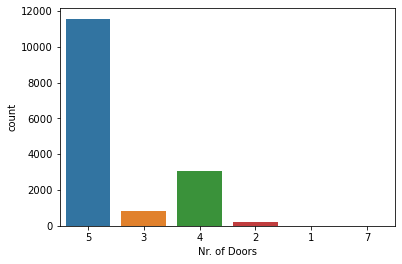

In [169]:
sns.countplot(df["Nr. of Doors"])